In [2]:
! conda run -n "darknet" pip install deeplabcut
! conda run -n "darknet" pip install tensorflow-gpu==1.15 

  Created wheel for absl-py: filename=absl_py-0.9.0-py3-none-any.whl size=121931 sha256=7b682f79afa72334e1928913f4aa5d19108f6e483936c7f1551259cdb61d15d5
  Stored in directory: /root/.cache/pip/wheels/c3/af/84/3962a6af7b4ab336e951b7877dcfb758cf94548bb1771e0679
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7539 sha256=b40ec02e105c3633a82863dc8d4b9aabf8f6d9047438391393b36a2cb4042ac3
  Stored in directory: /root/.cache/pip/wheels/19/a7/b9/0740c7a3a7d1d348f04823339274b90de25fbcd217b2ee1fbe
  Created wheel for wrapt: filename=wrapt-1.12.1-cp36-cp36m-linux_x86_64.whl size=69744 sha256=15d01b9af8cae40423a98a12c974823afe6540a1bee9e55c06d1097f30216b82
  Stored in directory: /root/.cache/pip/wheels/32/42/7f/23cae9ff6ef66798d00dc5d659088e57dbba01566f6c60db63
Successfully built absl-py gast wrapt



In [9]:
import darknet
import cv2 
import deeplabcut
import numpy as np
import tensorflow as tf
import logging
import sys
import matplotlib.pyplot as plt

from pathlib import Path
from ruamel.yaml import YAML
yaml = YAML()

In [2]:
logging.basicConfig(level=logging.DEBUG, stream=sys.stdout)
logging.info('Logging started')

INFO:root:Logging started


# Darknet 

In [3]:
configPath = "/storage/gs/rat-emotion/darknet/cfg/2020-06-02_yolo-obj.cfg"
weightPath = "/storage/gs/rat-emotion/darknet/weights/2020-06-07/2020-06-02_yolo-obj_last.weights"
video = "/storage/gs/rat-emotion/videos/24fps/rat8-control2.mp4"
metaPath = "/storage/gs/rat-emotion/darknet/labeled_data/2020-06-07/obj.data"

In [6]:
net = darknet.load_net_custom(configPath.encode("ascii"), weightPath.encode("ascii"), 0, 1)
meta = darknet.load_meta(metaPath.encode("ascii"))
net_width, net_height = (darknet.network_width(net), darknet.network_height(net))

cap = cv2.VideoCapture(video)

In [75]:
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
im, arr = darknet.array_to_image(frame)
res = darknet.detect_image(net, meta, im, thresh=.5, hier_thresh=.5, nms=.45, debug= False)
res

[(b'rat',
  0.9935916662216187,
  (987.1489868164062,
   982.1409912109375,
   618.6430053710938,
   501.31817626953125))]

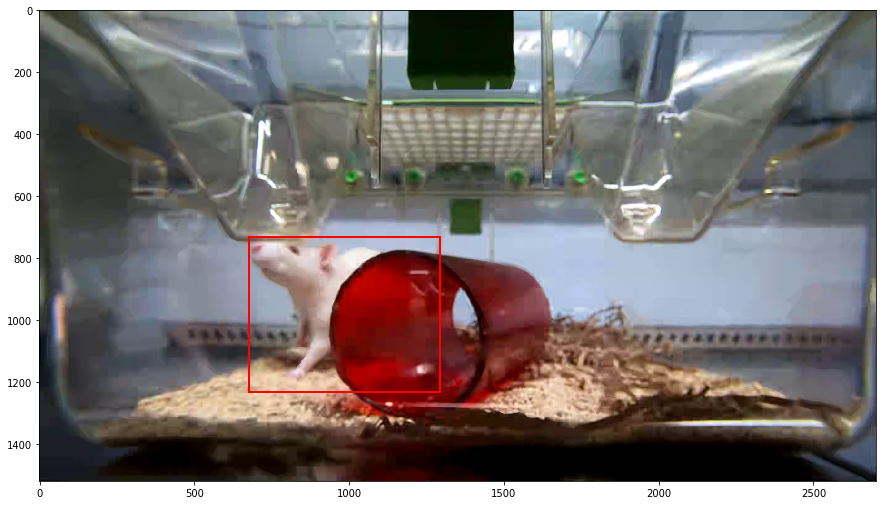

In [76]:
%matplotlib inline
plt.figure(figsize=(15,15))

test = frame.copy()
for obj in res:
    name, confidence, (x, y, w, h) = obj
    x0, y0 = int(x - w/2), int(y - h/2)
    x1, y1 = int(x + w/2), int(y + h/2)
    test = cv2.rectangle(test, (x0,y0), (x1, y1), (255,0,0), 5)

plt.imshow(test)

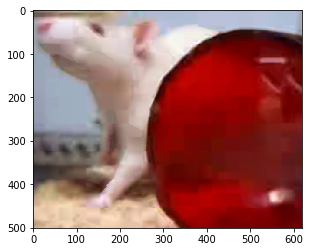

In [77]:
test = frame.copy()

name, confidence, (x, y, w, h) = res[0]
x0, y0 = int(x - w/2), int(y - h/2)
x1, y1 = int(x + w/2), int(y + h/2)
test = test[y0:y1, x0:x1]

plt.imshow(test)

# Deeplabcut

### Download minimal files from gs

In [13]:
class URL(str):
    def __truediv__(str, value):
        return URL(str + '/' + value)

In [53]:
project_path = URL('gs://rat-emotion/dlc/Darknet-MousePose-AndreTelfer-2020-06-09')
config_path = project_path / 'config.yaml'
train_dir = project_path / 'dlc-models/iteration-0/Darknet-MousePoseJun9-trainset95shuffle1/train' 
test_dir = project_path / 'dlc-models/iteration-0/Darknet-MousePoseJun9-trainset95shuffle1/test' 
snapshot = 'snapshot-78000'

batch_size = 32

In [44]:
import tempfile

tempdir = tempfile.TemporaryDirectory()
try:
    # Copy the snapshot weights from google drive
    ! gsutil cp {train_dir / snapshot + '*'} {tempdir.name}
    
    # Copy the config file
    ! gsutil cp {project_path / 'config.yaml'} {tempdir.name}
    
    # Copy the pose_cfg
    ! gsutil cp {test_dir / 'pose_cfg.yaml'} {tempdir.name}
    
    # Load the configs 
    tempdir_path = Path(tempdir.name)
    with open(tempdir_path / 'config.yaml', 'r') as fp:
        cfg = yaml.load(fp)


    # Set init weights
    dlc_cfg["init_weights"] = tempdir_path / snapshot
    
    # Other settings
    dlc_cfg["num_outputs"] = cfg.get("num_outputs", dlc_cfg.get("num_outputs", 1))
    dlc_cfg["batch_size"] = batch_size
    cfg["batch_size"] = batch_size
        
finally:
#     tempdir.cleanup()
    pass


Copying gs://rat-emotion/dlc/Darknet-MousePose-AndreTelfer-2020-06-09/dlc-models/iteration-0/Darknet-MousePoseJun9-trainset95shuffle1/train/snapshot-78000.data-00000-of-00001...
Copying gs://rat-emotion/dlc/Darknet-MousePose-AndreTelfer-2020-06-09/dlc-models/iteration-0/Darknet-MousePoseJun9-trainset95shuffle1/train/snapshot-78000.index...
Copying gs://rat-emotion/dlc/Darknet-MousePose-AndreTelfer-2020-06-09/dlc-models/iteration-0/Darknet-MousePoseJun9-trainset95shuffle1/train/snapshot-78000.meta...
| [3 files][ 95.3 MiB/ 95.3 MiB]                                                
Operation completed over 3 objects/95.3 MiB.                                     
Copying gs://rat-emotion/dlc/Darknet-MousePose-AndreTelfer-2020-06-09/config.yaml...
/ [1 files][  1.5 KiB/  1.5 KiB]                                                
Operation completed over 1 objects/1.5 KiB.                                      
Copying gs://rat-emotion/dlc/Darknet-MousePose-AndreTelfer-2020-06-09/dlc-models/ite

In [66]:
dlc_cfg

{'stride': 8.0,
 'weigh_part_predictions': False,
 'weigh_negatives': False,
 'fg_fraction': 0.25,
 'weigh_only_present_joints': False,
 'mean_pixel': [123.68, 116.779, 103.939],
 'shuffle': True,
 'snapshot_prefix': '/tmp/tmp8uk0yq9s/snapshot',
 'log_dir': 'log',
 'global_scale': 0.8,
 'location_refinement': True,
 'locref_stdev': 7.2801,
 'locref_loss_weight': 1.0,
 'locref_huber_loss': True,
 'optimizer': 'sgd',
 'intermediate_supervision': False,
 'intermediate_supervision_layer': 12,
 'regularize': False,
 'weight_decay': 0.0001,
 'mirror': False,
 'crop_pad': 0,
 'scoremap_dir': 'test',
 'batch_size': 1,
 'dataset_type': 'default',
 'deterministic': False,
 'crop': False,
 'cropratio': 0.25,
 'minsize': 100,
 'leftwidth': 400,
 'rightwidth': 400,
 'topheight': 400,
 'bottomheight': 400,
 'all_joints': [[0],
  [1],
  [2],
  [3],
  [4],
  [5],
  [6],
  [7],
  [8],
  [9],
  [10],
  [11],
  [12],
  [13],
  [14],
  [15]],
 'all_joints_names': ['nose',
  'left-ear',
  'right-ear',
  'l

In [68]:
from deeplabcut.pose_estimation_tensorflow.nnet import predict
from deeplabcut.pose_estimation_tensorflow.nnet.net_factory import pose_net
from deeplabcut.pose_estimation_tensorflow.config import load_config

dlc_cfg = load_config(tempdir_path / 'pose_cfg.yaml')
dlc_cfg['init_weights'] = str(tempdir_path / snapshot)
sess, inputs, outputs = predict.setup_GPUpose_prediction(dlc_cfg)

Initializing ResNet
INFO:tensorflow:Restoring parameters from /tmp/tmp8uk0yq9s/snapshot-78000


INFO:tensorflow:Restoring parameters from /tmp/tmp8uk0yq9s/snapshot-78000


In [ ]:
sess.run(outputs, feed_dict={inputs: im})

In [82]:
from skimage.util import img_as_ubyte
test_image = img_as_ubyte(test)

im = np.expand_dims(test_image, axis=0).astype(float)
outputs_np = sess.run(outputs, feed_dict={inputs: im})
    
# pose = predict.getpose(test_b, dlc_cfg, sess, inputs, outputs).flatten()

In [85]:
outputs_np

[array([[1.9567905e+01, 2.4360119e+01, 8.8515240e-01],
        [2.3134893e+01, 2.7112274e+02, 8.7346578e-01],
        [2.1844067e+01, 2.6425726e+02, 6.3481951e-01],
        [3.5583317e+01, 1.5323390e+02, 5.4264867e-01],
        [5.0719368e+01, 1.4522266e+02, 6.0874277e-01],
        [3.9321964e+01, 1.3114186e+02, 4.9681038e-01],
        [4.9898884e+01, 1.6410095e+02, 9.4565064e-01],
        [3.6228161e+01, 1.3734308e+02, 9.9333525e-02],
        [5.1300457e+01, 1.5696295e+02, 1.0776454e-01],
        [4.9703865e+01, 1.6323576e+02, 2.0872879e-01],
        [4.7085934e+01, 1.3955634e+02, 5.7169855e-02],
        [5.6192425e+01, 1.5745673e+02, 4.8190475e-02],
        [3.7984676e+01, 1.0507870e-01, 3.2338321e-02],
        [2.6630793e+00, 2.0144677e+00, 2.4086952e-02],
        [2.9125650e+01, 2.0759039e+01, 6.4472973e-01],
        [3.1319469e+01, 2.3600389e+01, 2.8335118e-01]], dtype=float32)]

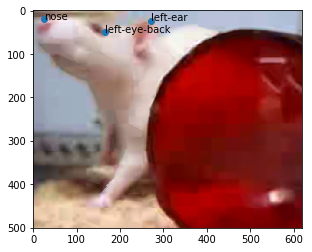

In [108]:
plt.imshow(test)

data = []
for i in range(len(cfg['bodyparts'])):
    y, x, c = outputs_np[0][i]
    if c < 0.7: continue
    bodypart = cfg['bodyparts'][i]
    data.append({
        'x': x,
        'y': y,
        'c': c,
        'bodypart': bodypart
    })

    plt.text(x, y, bodypart)
    
x, y, bodypart = zip(*[[item['x'], item['y'], item['bodypart']] for item in data])

plt.scatter(x, y)

In [109]:
tempdir.cleanup()